# Make 1d-trigger efficiency plots
- loads an output pkl file processed by the `trigger_efficiencies_processor.py` June 26th iteration which applies the the dxy, dz requirements on the Muons - hence applies all analysis selection

In [1]:
import glob
import json
import os
import pickle
import pickle as pkl

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import yaml
from hist.intervals import clopper_pearson_interval
from scipy.special import softmax
from sklearn.metrics import auc, roc_curve

pd.options.mode.chained_assignment = None

plt.rcParams.update({"font.size": 20})
plt.style.use(hep.style.CMS)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
trg_dict, var_dict, weight_dict = {}, {}, {}
for sample in ["ggF", "data"]:
    trg_dict[sample], var_dict[sample], weight_dict[sample] = {}, {}, {}

with open("trg_eff/outfiles/0-100_analysis.pkl", "rb") as f:
    out = pkl.load(f)["2017"]["GluGluHToWW_Pt-200ToInf_M-125"]["skimmed_events"]
    
    channels = out.keys()
    
    for ch in channels:
        trg_dict["ggF"][ch] = out[ch]["triggers"]
        var_dict["ggF"][ch] = out[ch]["vars"]
        weight_dict["ggF"][ch] = out[ch]["weights"]
        
        # must reshape this var
        var_dict["ggF"][ch]["fj_genH_pt"] = var_dict["ggF"][ch]["fj_genH_pt"].reshape(-1)
        
with open("trg_eff/outfiles/0-100_ele.pkl", "rb") as f:
    out = pkl.load(f)["2017"]["SingleElectron_Run2017C"]["skimmed_events"]

    trg_dict["data"]["ele"] = out["ele"]["triggers"]
    var_dict["data"]["ele"] = out["ele"]["vars"]
    weight_dict["data"]["ele"] = out["ele"]["weights"]

with open("trg_eff/outfiles/0-100_mu.pkl", "rb") as f:
    out = pkl.load(f)["2017"]["SingleMuon_Run2017C"]["skimmed_events"]

    trg_dict["data"]["mu"] = out["mu"]["triggers"]
    var_dict["data"]["mu"] = out["mu"]["vars"]
    weight_dict["data"]["mu"] = out["mu"]["weights"]        

# Lepton kinematics

In [4]:
outdir = f"/Users/fmokhtar/Desktop/AN_2024/trigger/"

if not os.path.exists(outdir):
    os.makedirs(outdir)

In [5]:
nice_channel = {
    "ele": "Electron",
    "mu": "Muon",
}

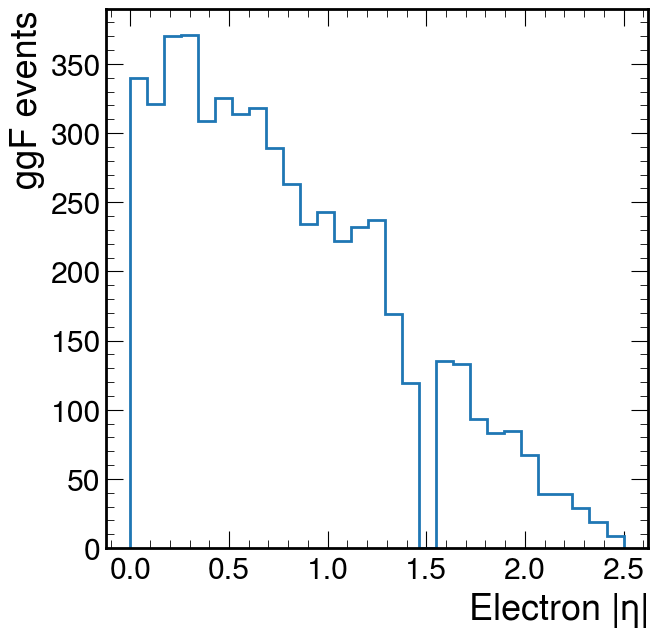

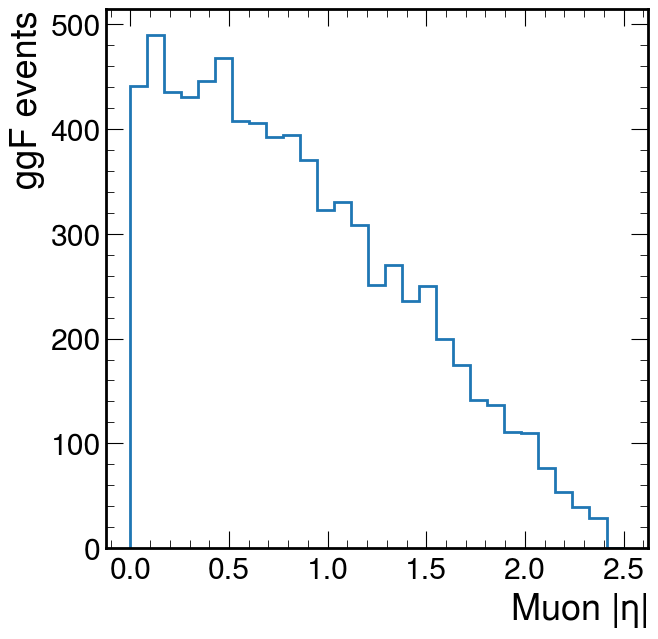

In [6]:
for ch in channels:
    fig, ax = plt.subplots(figsize=(7,7))

    ax.hist(
        abs(var_dict["ggF"][ch]["lep_eta"]),
        bins=np.linspace(0,2.5,30),
        histtype="step",
        lw=2,
    )

    ax.set_xlabel(nice_channel[ch] + r" $|\eta|$")
    ax.set_ylabel("ggF events");

    plt.savefig(f"{outdir}/{ch}_eta.pdf")

In [15]:
outdir

'/Users/fmokhtar/Desktop/AN_2024/trigger/'

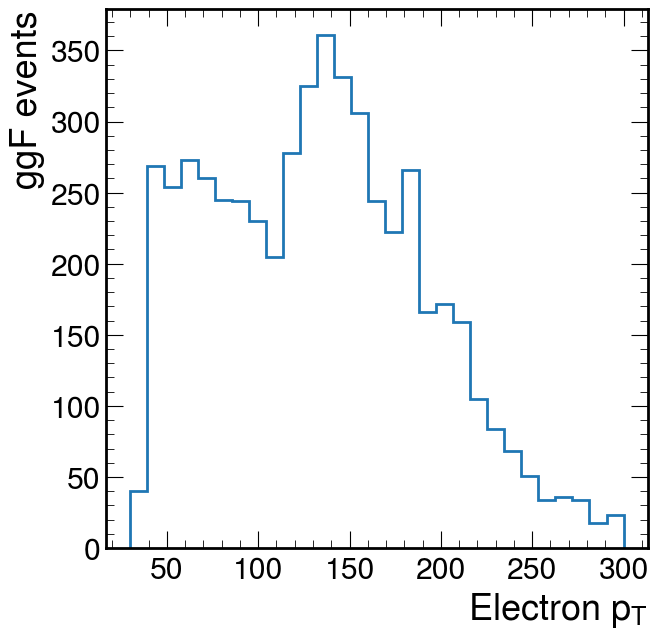

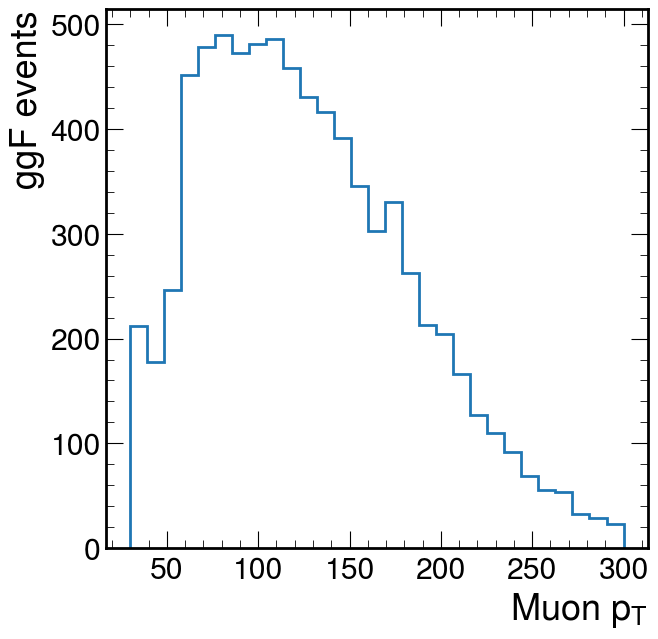

In [7]:
for ch in channels:

    fig, ax = plt.subplots(figsize=(7,7))

    ax.hist(
        var_dict["ggF"][ch]["lep_pt"],
        bins=np.linspace(30,300,30),
        histtype="step",
        lw=2,
    )

    ax.set_xlabel(nice_channel[ch] + r" $p_T$")
    ax.set_ylabel("ggF events");

    plt.savefig(f"{outdir}/{ch}_pt.pdf")

# 1d efficiency plots

In [8]:
hists, msk_trg = {}, {}

for sample in ["ggF", "data"]:
    hists[sample], msk_trg[sample] = {}, {}
    
    for ch in channels:

        hists[sample][ch] = hist2.Hist(
            hist2.axis.StrCategory([], name='trigger', growth=True),
            hist2.axis.Regular(4, 0, 2.5, name='lepeta', label=r'Lepton $|\eta|$ [GeV]'),
            hist2.axis.Regular(15, 30, 400, name='leppt', label=r'Lepton $p_T$ [GeV]'),
    #         hist2.axis.Regular(20, 30, 400, name='higgspt', label=r'Gen Higgs $p_T$ [GeV]'),
        )

        # save events after each trigger
        for trg in trg_dict[sample][ch]:
            hists[sample][ch].fill(
                trigger=trg,
                leppt=var_dict[sample][ch]["lep_pt"][trg_dict[sample][ch][trg]],
                lepeta=abs(var_dict[sample][ch]["lep_eta"])[trg_dict[sample][ch][trg]],
            )

        # save events before trigger        
        hists[sample][ch].fill(
            trigger="before_triggers",
            leppt=var_dict[sample][ch]["lep_pt"],
            lepeta=abs(var_dict[sample][ch]["lep_eta"]),
        )

        ########## build the OR of all triggers
        msk_trg[sample][ch] = np.zeros(len(var_dict[sample][ch]["lep_pt"]), dtype="bool")

        for trig in trg_dict[sample][ch]:
            msk_trg[sample][ch] = msk_trg[sample][ch] | trg_dict[sample][ch][trig]

        # save an events before trigger
        hists[sample][ch].fill(
            trigger="or_of_triggers",
            leppt=var_dict[sample][ch]["lep_pt"][msk_trg[sample][ch]],
            lepeta=abs(var_dict[sample][ch]["lep_eta"])[msk_trg[sample][ch]],
        )

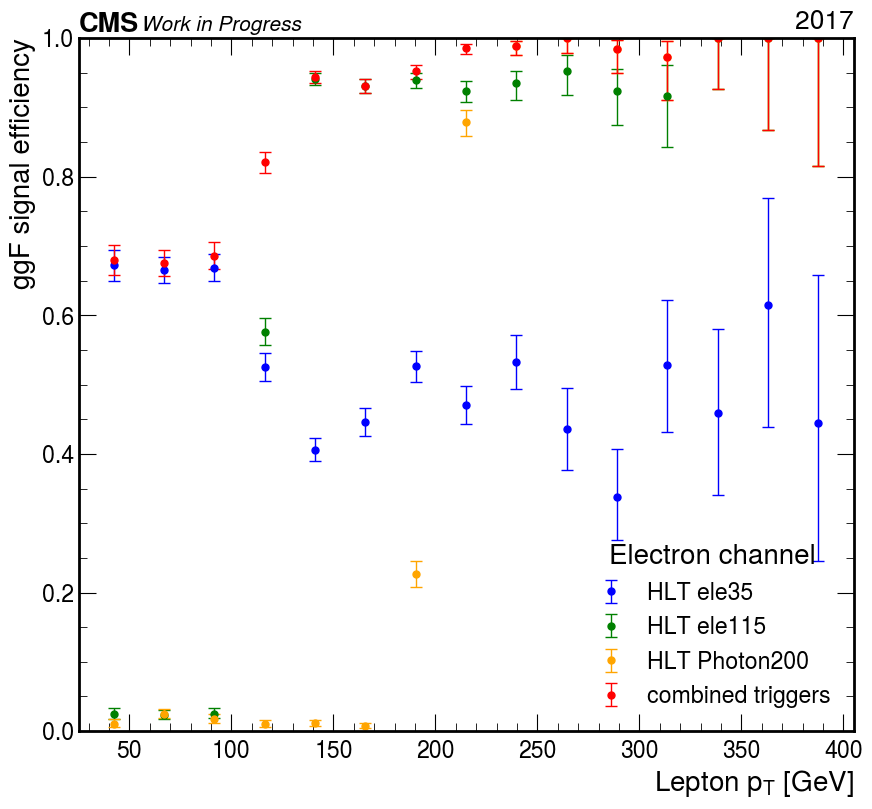

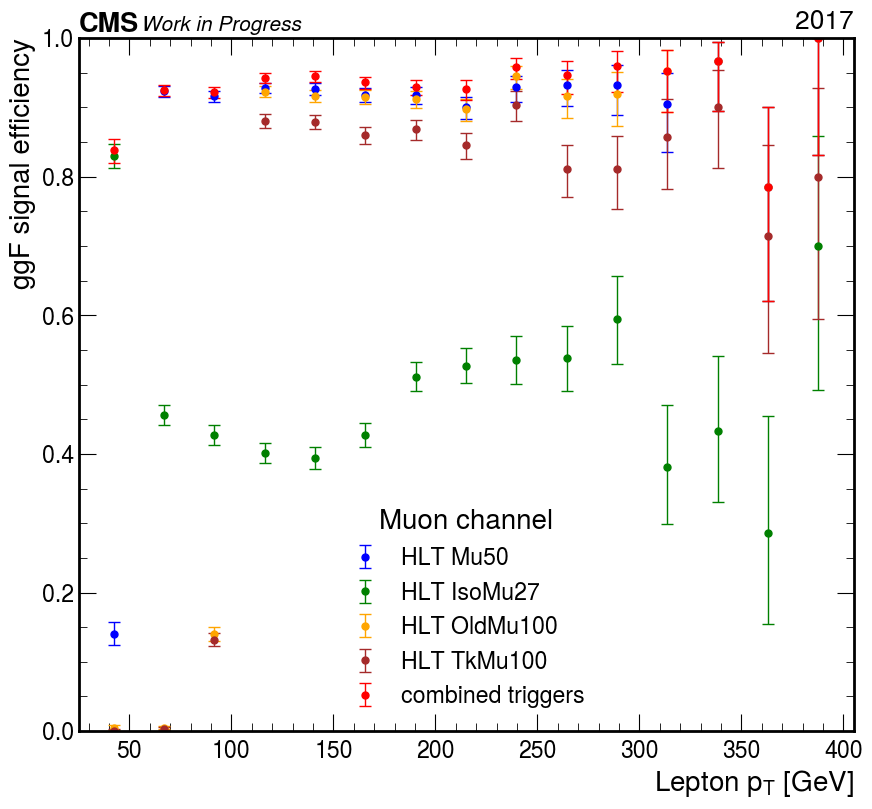

In [13]:
plt.rcParams.update({"font.size": 20})


colors_dict = {
    "combined triggers": "red",
    "HLT_Ele35_WPTight_Gsf": "blue",
    "HLT_Ele115_CaloIdVT_GsfTrkIdT": "green",
    "HLT_Photon200": "orange",
    
    "HLT_Mu50": "blue",
    "HLT_IsoMu27": "green",
    "HLT_OldMu100": "orange",    
    "HLT_TkMu100": "brown"
}

trg_label_dict = {
    "HLT_Ele35_WPTight_Gsf": "HLT ele35",
    "HLT_Ele115_CaloIdVT_GsfTrkIdT": "HLT ele115",
    "HLT_Photon200": "HLT Photon200",
    
    "HLT_Mu50": "HLT Mu50",
    "HLT_IsoMu27": "HLT IsoMu27",
    "HLT_OldMu100": "HLT OldMu100",    
    "HLT_TkMu100": "HLT TkMu100"
}


def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

for ch in channels:

    fig, ax = plt.subplots(figsize=(10,9))

    den = hists["ggF"][ch][{"trigger": "before_triggers", 'lepeta': sum}]

    for trg in trg_dict["ggF"][ch]:

        num = hists["ggF"][ch][{"trigger": trg, 'lepeta': sum}]
        hep.histplot(num/den,
                     ax = ax,
                     label=trg_label_dict[trg],
                     color=colors_dict[trg],
                     histtype='errorbar', 
                     yerr=get_yerr(num, den),
                     capsize=4, 
                     elinewidth=1,
                     flow=None,
        )

    num = hists["ggF"][ch][{"trigger": "or_of_triggers", 'lepeta': sum}]
    hep.histplot(num/den,
                 ax = ax,
                 label="combined triggers",
                 color=colors_dict["combined triggers"],                 
                 histtype='errorbar', 
                 yerr=get_yerr(num, den),
                 capsize=4, 
                 elinewidth=1,
                 flow=None,             
    )
    
    ax.set_ylim(0,1)
    ax.legend(title=f"{nice_channel[ch]} channel")
    ax.set_ylabel("ggF signal efficiency")
    hep.cms.lumitext(
        "2017", ax=ax, fontsize=20
    )
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)

#     plt.savefig(f"{outdir}/{ch}_trgeff_1d_leppt.pdf")

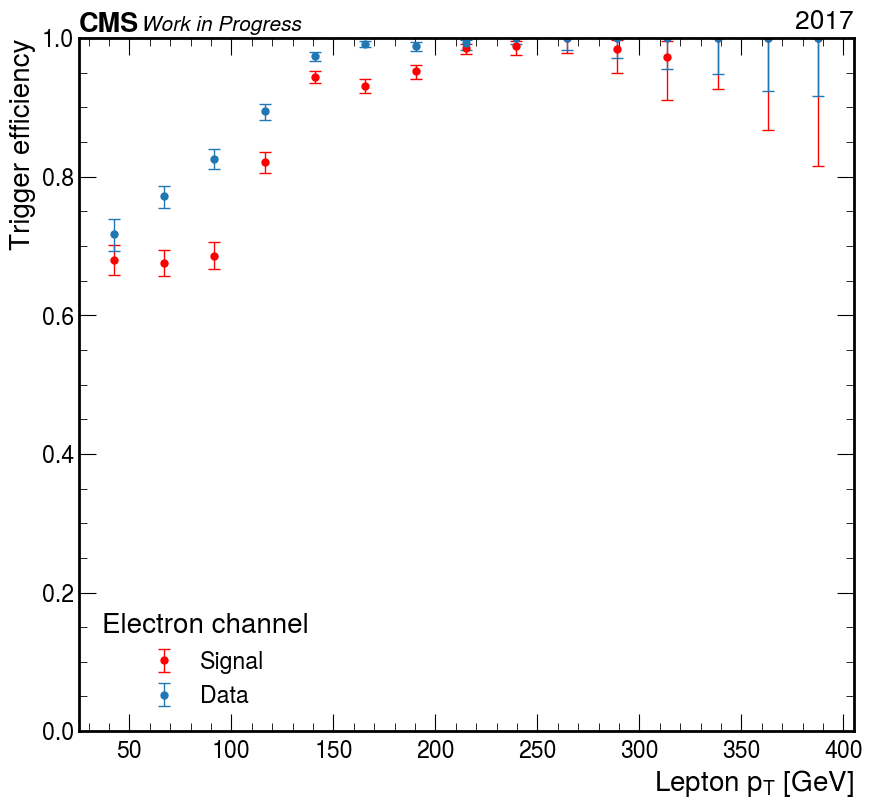

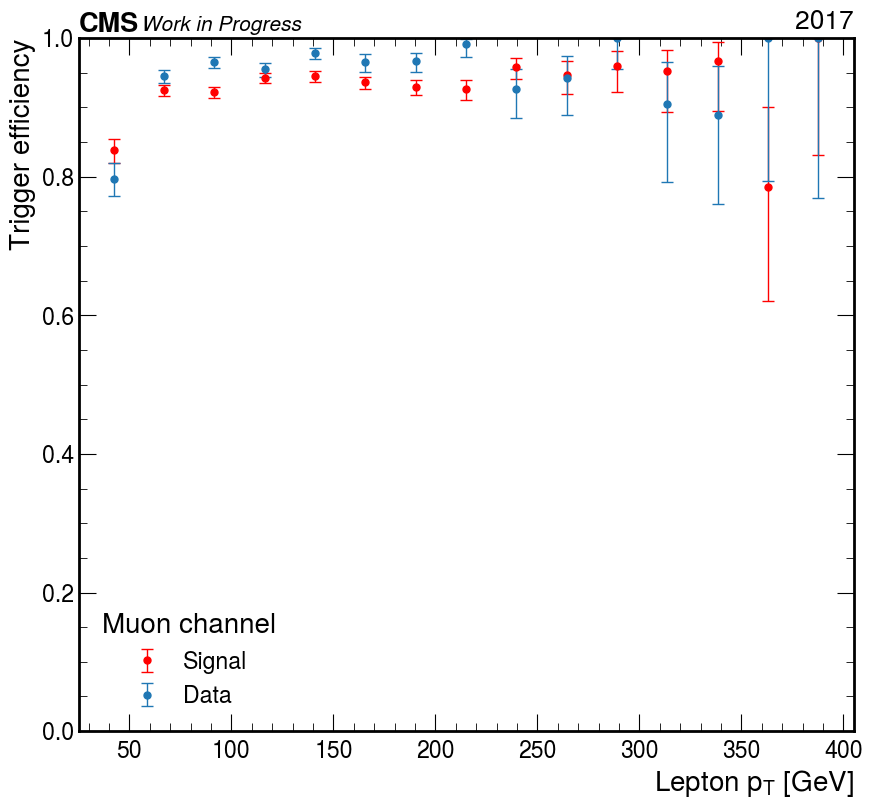

In [14]:
plt.rcParams.update({"font.size": 20})


colors_dict = {
    "combined triggers": "red",
    "HLT_Ele35_WPTight_Gsf": "blue",
    "HLT_Ele115_CaloIdVT_GsfTrkIdT": "green",
    "HLT_Photon200": "orange",
    
    "HLT_Mu50": "blue",
    "HLT_IsoMu27": "green",
    "HLT_OldMu100": "orange",    
    "HLT_TkMu100": "brown"
}

def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

for ch in channels:

    fig, ax = plt.subplots(figsize=(10,9))

    # signal
    den = hists["ggF"][ch][{"trigger": "before_triggers", 'lepeta': sum}]

    num = hists["ggF"][ch][{"trigger": "or_of_triggers", 'lepeta': sum}]
    hep.histplot(num/den,
                 ax = ax,
                 label="Signal",
                 color=colors_dict["combined triggers"],                 
                 histtype='errorbar', 
                 yerr=get_yerr(num, den),
                 capsize=4, 
                 elinewidth=1,
                 flow=None,             
    )

    # data
    num = hists["data"][ch][{"trigger": "or_of_triggers", 'lepeta': sum}]
    den = hists["data"][ch][{"trigger": "before_triggers", 'lepeta': sum}]
    hep.histplot(num/den,
                 ax = ax,
                 label="Data",
#                      color=colors_dict["combined triggers"],                 
                 histtype='errorbar', 
                 yerr=get_yerr(num, den),
                 capsize=4, 
                 elinewidth=1,
                 flow=None,             
    )    
    
    ax.set_ylim(0,1)
    ax.legend(title=f"{nice_channel[ch]} channel")
    ax.set_ylabel("Trigger efficiency")
    hep.cms.lumitext(
        "2017", ax=ax, fontsize=20
    )
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)

    plt.savefig(f"{outdir}/{ch}_trgeff_1d_leppt_data.pdf")